In [2]:
# generation of data that follow n(r) ~ sigmoid

# spherical shell radius (Mpc)
R <- 440  
# spherical shell thickness (in the order of kpc)
DeltaR <- R * 10^(-3) 
# population numerical density (Mpc^-3 s^-1)
n <- 3e-12 
# observation time (s, about 1 year )
T <- 3e7 

# rate parameter of the Poisson distribution
lambda_pois <- n * T * 4 * pi * R^2 * DeltaR

# number of sources
N <- seq(floor(lambda_pois-5*sqrt(lambda_pois)), floor(lambda_pois+5*sqrt(lambda_pois)))

# Poisson distribution
distrib_sources <- dpois(N, lambda_pois)

In [3]:
# parameters (arbitrary units)
h0 <- 120
w <- 25

# strain values (a.u.) assuming h ~ 10^-21 = 1000 (a.u.)
h <- 10^seq(-3, 7, 0.001)

# efficiency curve in function of h
efficiency <- pnorm(h, mean = h0, sd = w)

In [4]:
# efficiency as a function of r

# distances (Mpc)
r <- 1e5/h # took 1e5 as the proportionality factor so that for r = 440 Mpc \epsilon ~ 1 
r <- r[r >= 20 & r <= 1e+4] # we suppose to observe from 20 Mpc until 10 Gpc

epsilon_r <- pnorm(1e5/r, h0, w)

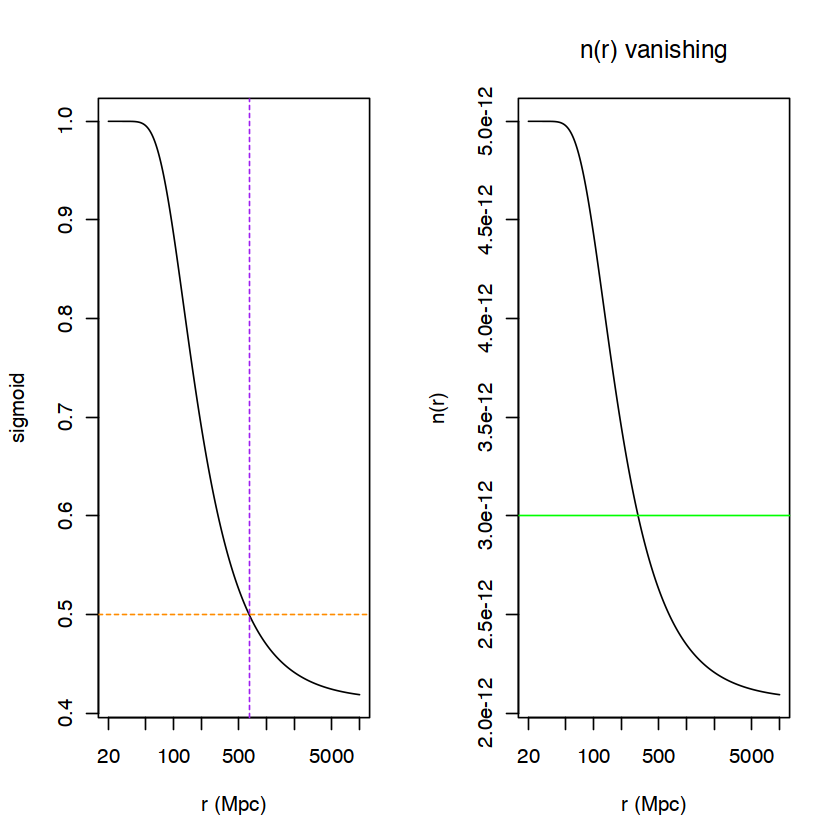

In [5]:
# sigmoid to explain the number of sources as a function of distances
r0_new <- 650
h0_new <- 1e5/r0_new
w_new <- 700
sigmoid <- pnorm(1e5/r, h0_new, w_new)
n_s <- 5e-12

par(mfrow = c(1, 2))

plot(r, sigmoid, log = 'x', 'l', xlab = 'r (Mpc)')
abline(v = r0_new, col = 'purple', lty = 2)
abline(h = 0.5, col = 'darkorange', lty = 2)

n_r <- n_s * sigmoid

plot(r, n_r, 'l', ylab = 'n(r)', log = 'x', 
    main = "n(r) vanishing", xlab = 'r (Mpc)')
abline(h = n, col = 'green')

In [6]:
set.seed(1)

prova <- matrix(NA, nrow = 10, ncol = 5)

for(i in 1:5){
    prova[, i] <- rnorm(10)
}

print(prova)

            [,1]        [,2]        [,3]        [,4]       [,5]
 [1,] -0.6264538  1.51178117  0.91897737  1.35867955 -0.1645236
 [2,]  0.1836433  0.38984324  0.78213630 -0.10278773 -0.2533617
 [3,] -0.8356286 -0.62124058  0.07456498  0.38767161  0.6969634
 [4,]  1.5952808 -2.21469989 -1.98935170 -0.05380504  0.5566632
 [5,]  0.3295078  1.12493092  0.61982575 -1.37705956 -0.6887557
 [6,] -0.8204684 -0.04493361 -0.05612874 -0.41499456 -0.7074952
 [7,]  0.4874291 -0.01619026 -0.15579551 -0.39428995  0.3645820
 [8,]  0.7383247  0.94383621 -1.47075238 -0.05931340  0.7685329
 [9,]  0.5757814  0.82122120 -0.47815006  1.10002537 -0.1123462
[10,] -0.3053884  0.59390132  0.41794156  0.76317575  0.8811077


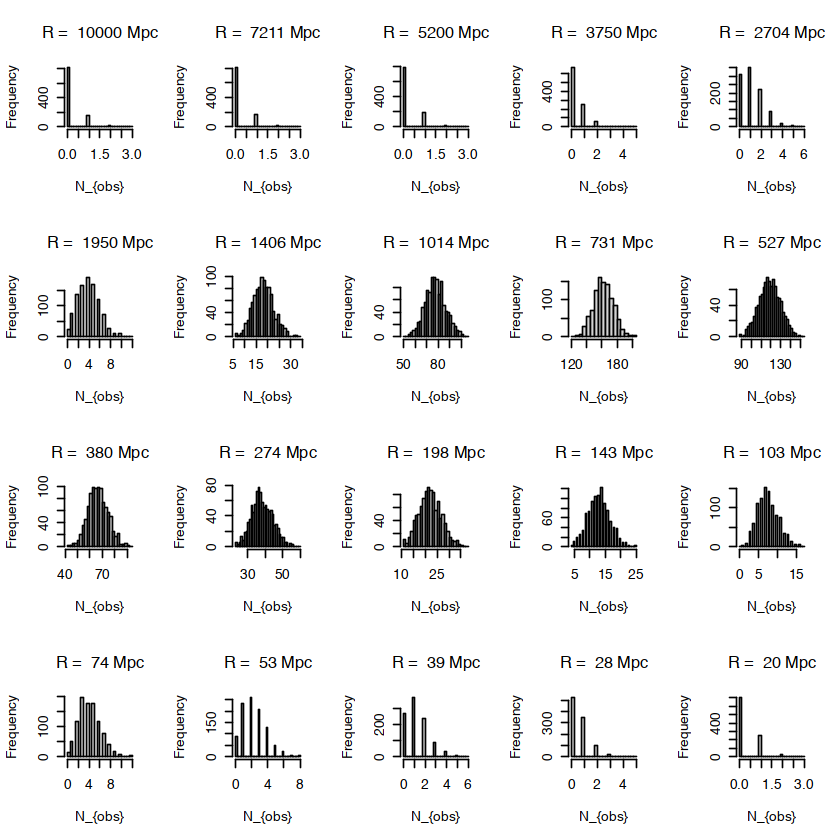

In [7]:
sample_dim_mcmc <- 1e3
lambda_simul_r <- 4 * pi * r^2 * DeltaR * n_r * T * epsilon_r 

par(mfrow = c(4, 5))
samples <- matrix(NA, nrow = sample_dim_mcmc, ncol = length(lambda_simul_r))

for(i in 1:length(lambda_simul_r)){
    samples[, i] <- rpois(sample_dim_mcmc, lambda_simul_r[i])
}

# observed sources simulations histograms
for(i in seq(1, length(lambda_simul_r), length.out = 20)){
    hist(
        samples[, i], breaks = 30,
        main = paste("R = ", round(r[i], 0), "Mpc"),
        xlab = 'N_{obs}'
    )
}

In [8]:
samples <- as.data.frame(samples)

In [9]:
# we want to infer n(r) from a distribution, for example from r = 1000 Mpc (i = 1001)
library(rjags)

r_sim <- 1000
data <- NULL
data$N <- samples[, 1001]
data$l <- 4 * pi * r_sim^2 * DeltaR * T * epsilon_r[r == r_sim]

Caricamento del pacchetto richiesto: coda



Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



In [18]:
jm <- jags.model("inference.bug", data)

update(jm, 1000)
chain <- coda.samples(jm, c('n_r'), n.iter = 5e4, thin = 10)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1000
   Unobserved stochastic nodes: 1
   Total graph size: 1005

Initializing model



In [15]:
summary(chain)


Iterations = 2001:52000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     2.349e-12      8.145e-15      3.642e-17      0.000e+00 

2. Quantiles for each variable:

     2.5%       25%       50%       75%     97.5% 
2.333e-12 2.343e-12 2.349e-12 2.354e-12 2.365e-12 


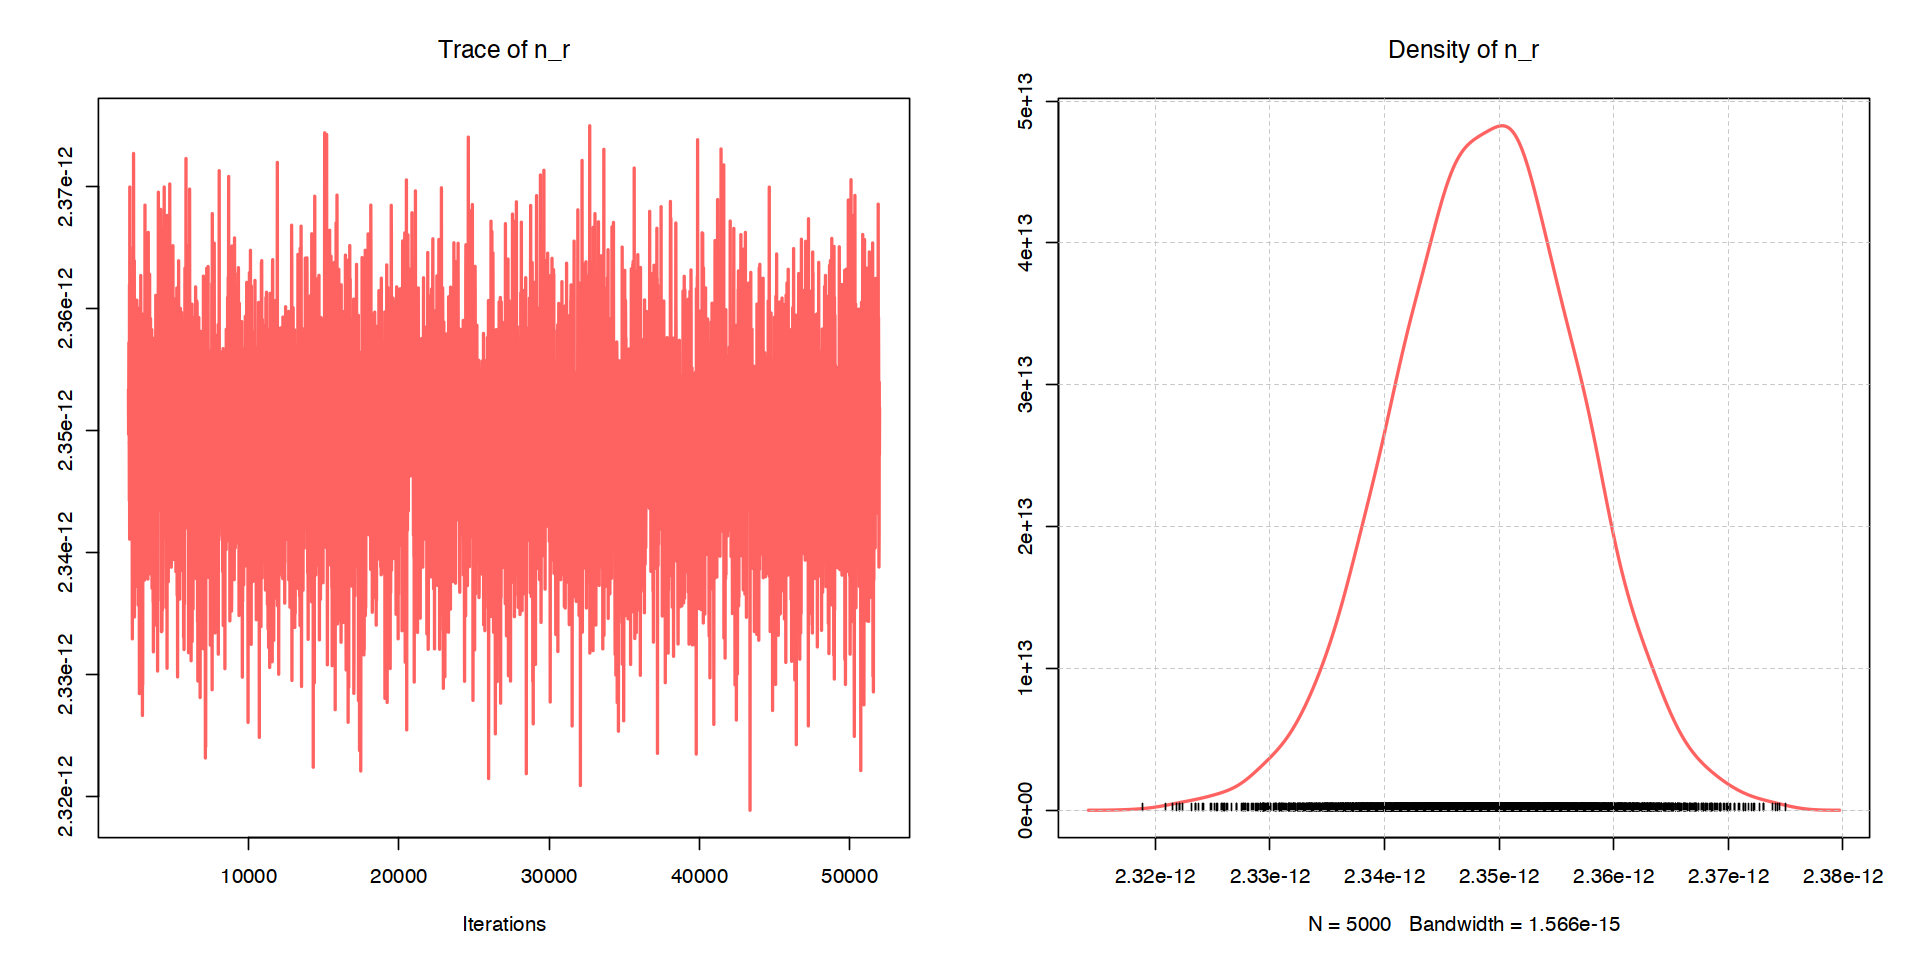

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow = c(1,2), oma = c(0, 0, 0, 0))

plot(chain, col = '#ff6361', lwd = 2)
grid(nx = NULL, ny = NULL,
	lty = 2, lwd = 0.5,
	col = 'gray')

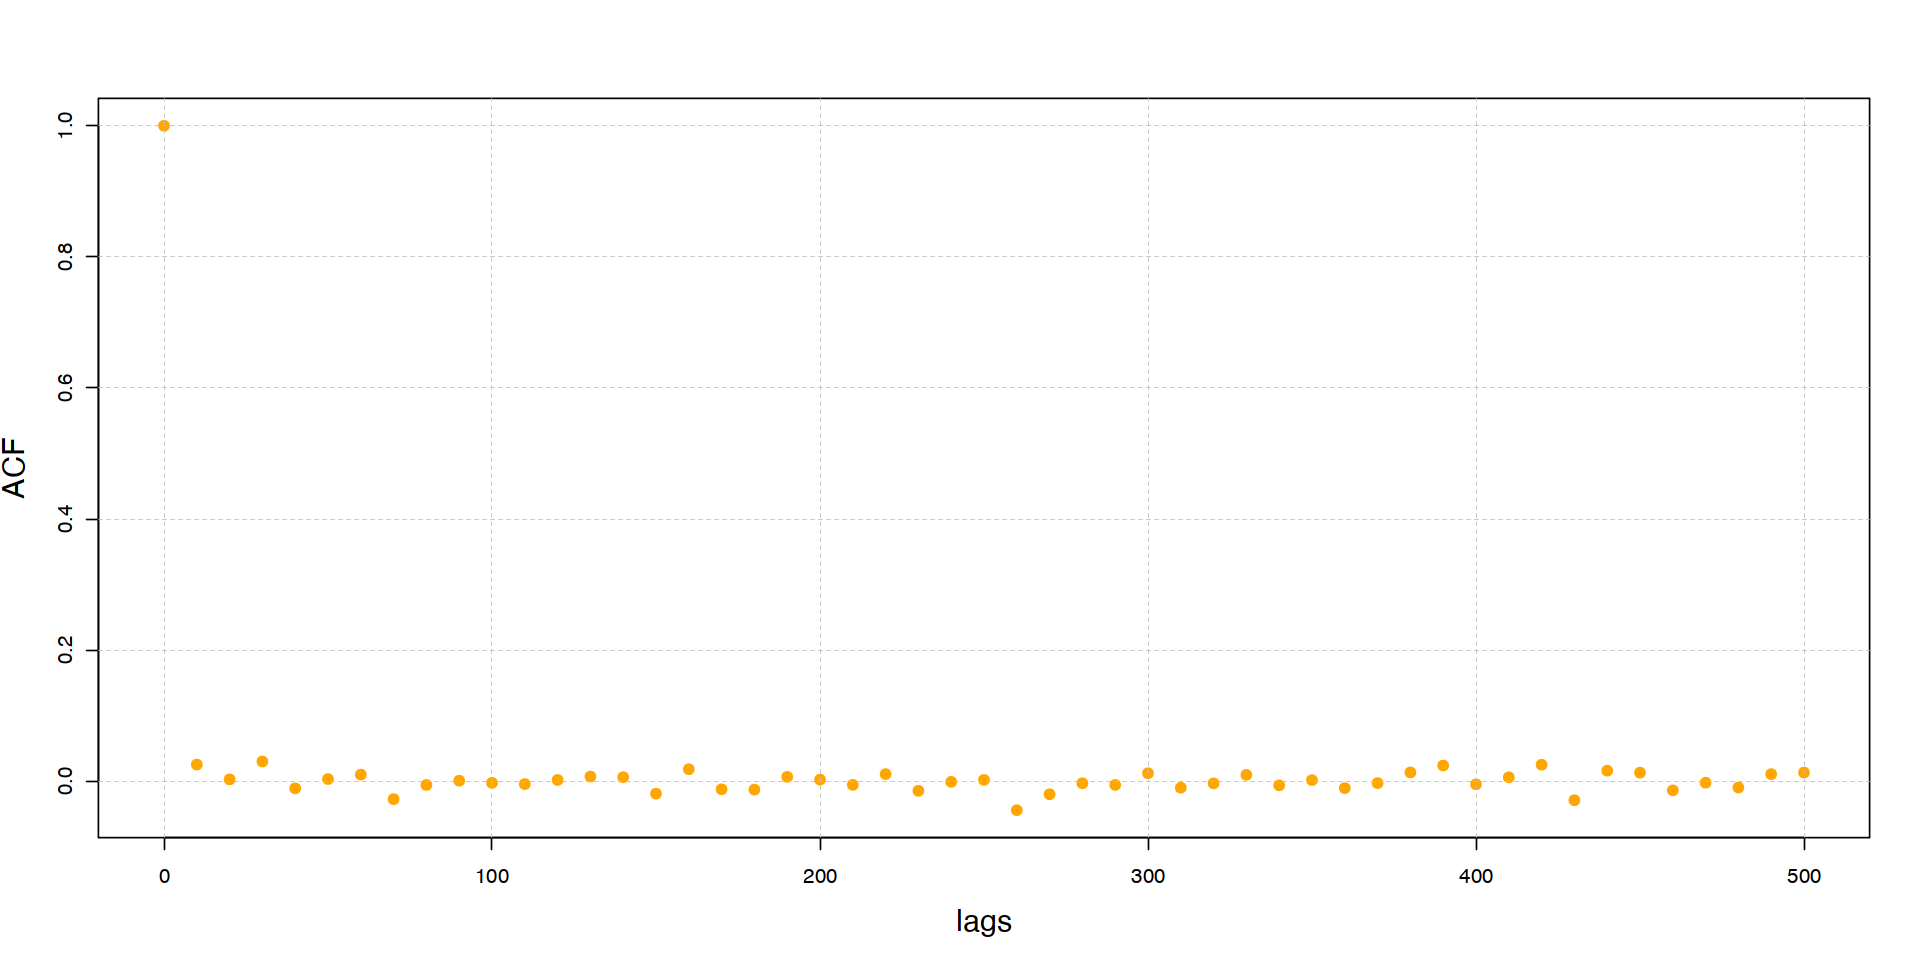

In [31]:
library(coda)
coda_chain <- as.mcmc(chain)

lags <- seq(0, 500, 10)
ACF <- autocorr(coda.chain, lags = lags)
eff_size <- effectiveSize(coda_chain)

plot(lags, ACF,
    pch = 19, col = '#ffa600',
    cex.lab = 1.5)
grid(nx = NULL, ny = NULL,
	lty = 2, lwd = 0.5,
	col = 'gray')

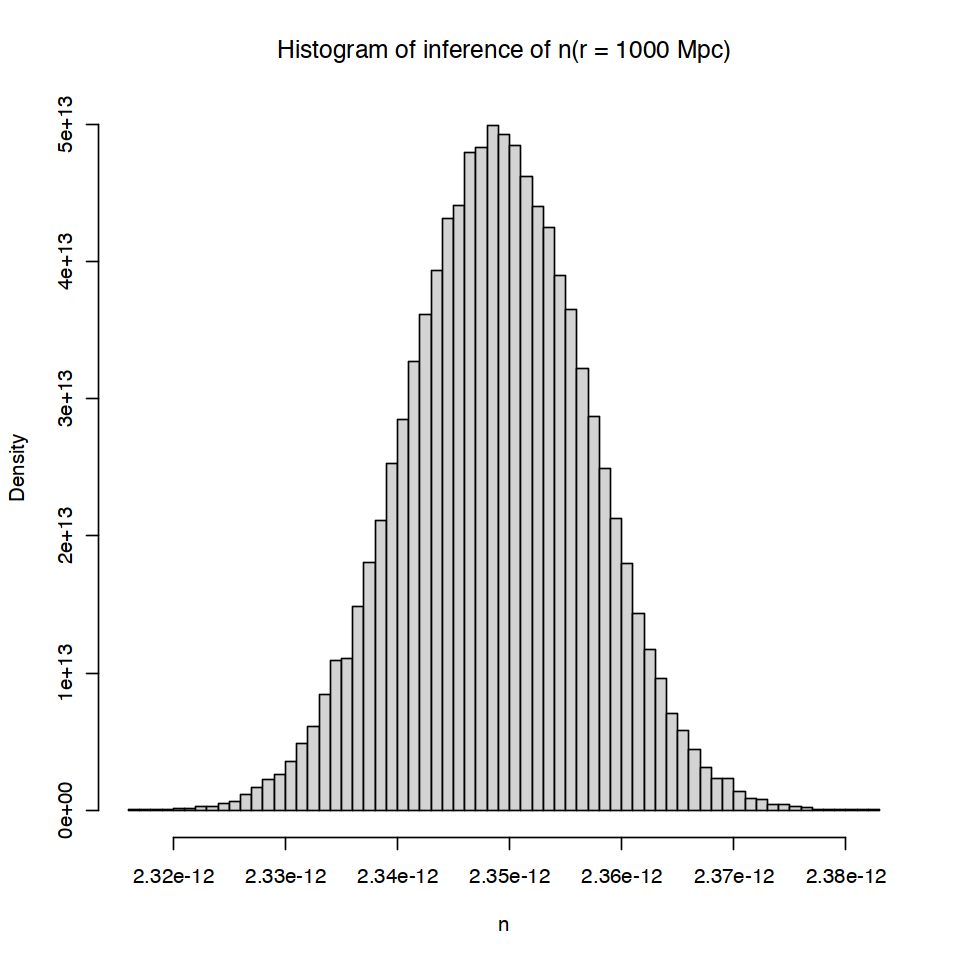

In [ ]:
chain_df <- as.data.frame(as.mcmc(chain))

# histogram the inference on n(r)
options(repr.plot.width = 8, repr.plot.height = 8)
hist(chain_df$n_r, nc = 50, prob = TRUE,
    xlab = 'n', main = 'Histogram of inference of n(r = 1000 Mpc)')

In [ ]:
# distances at which we do the analysis by varying T (Mpc)
r_T <- c(20, 50, 70, 100)

# time (year)
time <- seq(0.05, 10, length.out = 12)

# Poisson distribution rate as a function of r and time

# case n = const
lambda_time_nconst <- c()

for(i in 1:length(r_T)){
    lambda_time_nconst <- cbind( lambda_time_nconst, 4 * pi * r_T[i]^2 * DeltaR * time*T * pnorm(1e5/r_T[i], h0, w) * n  )
}

print(lambda_time_nconst)

             [,1]        [,2]       [,3]       [,4]
 [1,] 0.009952566  0.06220353  0.1219189  0.2488141
 [2,] 0.190003524  1.18752202  2.3275432  4.7500881
 [3,] 0.370054482  2.31284051  4.5331674  9.2513620
 [4,] 0.550105440  3.43815900  6.7387916 13.7526360
 [5,] 0.730156398  4.56347749  8.9444159 18.2539100
 [6,] 0.910207356  5.68879598 11.1500401 22.7551839
 [7,] 1.090258315  6.81411447 13.3556644 27.2564579
 [8,] 1.270309273  7.93943295 15.5612886 31.7577318
 [9,] 1.450360231  9.06475144 17.7669128 36.2590058
[10,] 1.630411189 10.19006993 19.9725371 40.7602797
[11,] 1.810462147 11.31538842 22.1781613 45.2615537
[12,] 1.990513105 12.44070691 24.3837855 49.7628276


In [ ]:
# case n = n(r)
lambda_time_nr <- c()

for(i in 1:length(r_T)){
    lambda_time_nr <- cbind( lambda_time_nr, 4 * pi * r_T[i]^2 * DeltaR * time*T * pnorm(1e5/r_T[i], h0_new, w_new) * n * pnorm(1e5/r_T[i], h0, w)  )
}

print(lambda_time_nr)

             [,1]        [,2]      [,3]       [,4]
 [1,] 0.009952566  0.06194367  0.117737  0.2206057
 [2,] 0.190003524  1.18256094  2.247707  4.2115633
 [3,] 0.370054482  2.30317822  4.377677  8.2025209
 [4,] 0.550105440  3.42379550  6.507646 12.1934785
 [5,] 0.730156398  4.54441277  8.637616 16.1844362
 [6,] 0.910207356  5.66503005 10.767586 20.1753938
 [7,] 1.090258314  6.78564732 12.897556 24.1663514
 [8,] 1.270309273  7.90626460 15.027526 28.1573090
 [9,] 1.450360231  9.02688188 17.157496 32.1482666
[10,] 1.630411189 10.14749915 19.287465 36.1392242
[11,] 1.810462147 11.26811643 21.417435 40.1301819
[12,] 1.990513105 12.38873370 23.547405 44.1211395


In [ ]:
# inference on n
set.seed(5)
sample_dim <- 1e5
# n = const
alpha_nconst <- c()

for(i in 1:length(r_T)){
    b <- c()

    for(j in 1:length(time)){
        b <- c(b, 1 + sum(rpois(sample_dim, lambda_time_nconst[j,i])))
    }

    alpha_nconst <- cbind(alpha_nconst, b)
}

print(alpha_nconst)

           b       b       b       b
 [1,]   1044    6168   12206   24957
 [2,]  18936  118037  231976  474935
 [3,]  37214  231395  453566  924630
 [4,]  54955  344162  672736 1376221
 [5,]  73390  456721  895583 1827851
 [6,]  90597  568107 1116663 2274172
 [7,] 108746  682383 1335157 2724371
 [8,] 127418  793243 1553651 3177606
 [9,] 144266  906191 1774515 3627594
[10,] 162957 1017049 1994218 4076320
[11,] 181179 1131220 2218520 4525669
[12,] 198310 1243453 2439833 4977956


In [ ]:

N_means_nconst <- c()
N_vars_nconst <- c()

for(i in 1:length(r_T)){

    a <- c()    # mean of posterior
    b_var <- c()    # variance of posterior

    for(j in 1:length(time)){
        a <- c(a, alpha_nconst[j,i]/sample_dim )
        b_var <- c(b_var, alpha_nconst[j,i]/(sample_dim^2) )
    }

    N_means_nconst <- cbind(N_means_nconst, a)
    N_vars_nconst <- cbind(N_vars_nconst, b_var)
}

print(N_means_nconst)

        a        a        a        a
b 0.01044  0.06168  0.12206  0.24957
b 0.18936  1.18037  2.31976  4.74935
b 0.37214  2.31395  4.53566  9.24630
b 0.54955  3.44162  6.72736 13.76221
b 0.73390  4.56721  8.95583 18.27851
b 0.90597  5.68107 11.16663 22.74172
b 1.08746  6.82383 13.35157 27.24371
b 1.27418  7.93243 15.53651 31.77606
b 1.44266  9.06191 17.74515 36.27594
b 1.62957 10.17049 19.94218 40.76320
b 1.81179 11.31220 22.18520 45.25669
b 1.98310 12.43453 24.39833 49.77956


In [ ]:
n_nconst <- c()
n_err_nconst <- c()

for(i in 1:length(r_T)){

    a2 <- c()
    b2 <- c()

    for(j in 1:length(time)){
        a2 <- c(a2, N_means_nconst[j,i]/(4 * pi * r_T[i]^2 * DeltaR * time[j]*T * pnorm(1e5/r_T[i], h0, w) ))
        b2 <- c(b2, sqrt(N_vars_nconst[j,i])/(4 * pi * r_T[i]^2 * DeltaR * time[j]*T * pnorm(1e5/r_T[i], h0, w)) )
    }

    n_nconst <- cbind(n_nconst, a2)
    n_err_nconst <- cbind(n_err_nconst, b2)
}

print(n_err_nconst)

                b2           b2           b2           b2
 [1,] 9.739495e-14 3.787724e-14 2.718547e-14 1.904769e-14
 [2,] 2.172720e-14 8.679379e-15 6.207905e-15 4.352479e-15
 [3,] 1.563899e-14 6.239540e-15 4.456970e-15 3.118168e-15
 [4,] 1.278436e-14 5.118901e-15 3.651418e-15 2.559054e-15
 [5,] 1.113073e-14 4.442739e-15 3.174112e-15 2.221957e-15
 [6,] 9.920597e-15 3.974806e-15 2.843190e-15 1.988166e-15
 [7,] 9.073994e-15 3.636855e-15 2.595505e-15 1.816707e-15
 [8,] 8.429992e-15 3.365386e-15 2.402993e-15 1.683921e-15
 [9,] 7.856468e-15 3.150469e-15 2.249309e-15 1.575849e-15
[10,] 7.427807e-15 2.969033e-15 2.121164e-15 1.485998e-15
[11,] 7.053192e-15 2.819846e-15 2.014779e-15 1.410046e-15
[12,] 6.711638e-15 2.689001e-15 1.921765e-15 1.345060e-15


In [ ]:

# n = n(r)
alpha_nr <- c()
for(i in 1:length(r_T)){

    b <- c()

    for(j in 1:length(time)){
        b <- c(b, 1 + sum(rpois(sample_dim, lambda_time_nr[j,i])))
    }

    alpha_nr <- cbind(alpha_nr, b)
}

rownames(alpha_nr) <- paste( round(time, 2), 'y' )
colnames(alpha_nr) <- paste( r_T, 'Mpc - n = n(r)' )

N_means_nr <- c()
N_vars_nr <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, alpha_nr[j,i]/sample_dim )
        b <- c(b, alpha_nr[j,i]/(sample_dim^2) )
    }

    N_means_nr <- cbind(N_means_nr, a)
    N_vars_nr <- cbind(N_vars_nr, b)
}

n_nr <- c()
n_err_nr <- c()

for(i in 1:length(r_T)){

    a <- c()
    b <- c()

    for(j in 1:length(time)){
        a <- c(a, N_means_nr[j,i]/(4 * pi * r_T[i]^2 * DeltaR * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w) ))
        b <- c(b, sqrt(N_vars_nr[j,i])/(4 * pi * r_T[i]^2 * DeltaR * time[j]*3*10^7 * pnorm(1e5/r_T[i], h0, w)) )
    }



    n_nr <- cbind(n_nr, a)
    n_err_nr <- cbind(n_err_nr, b)
}

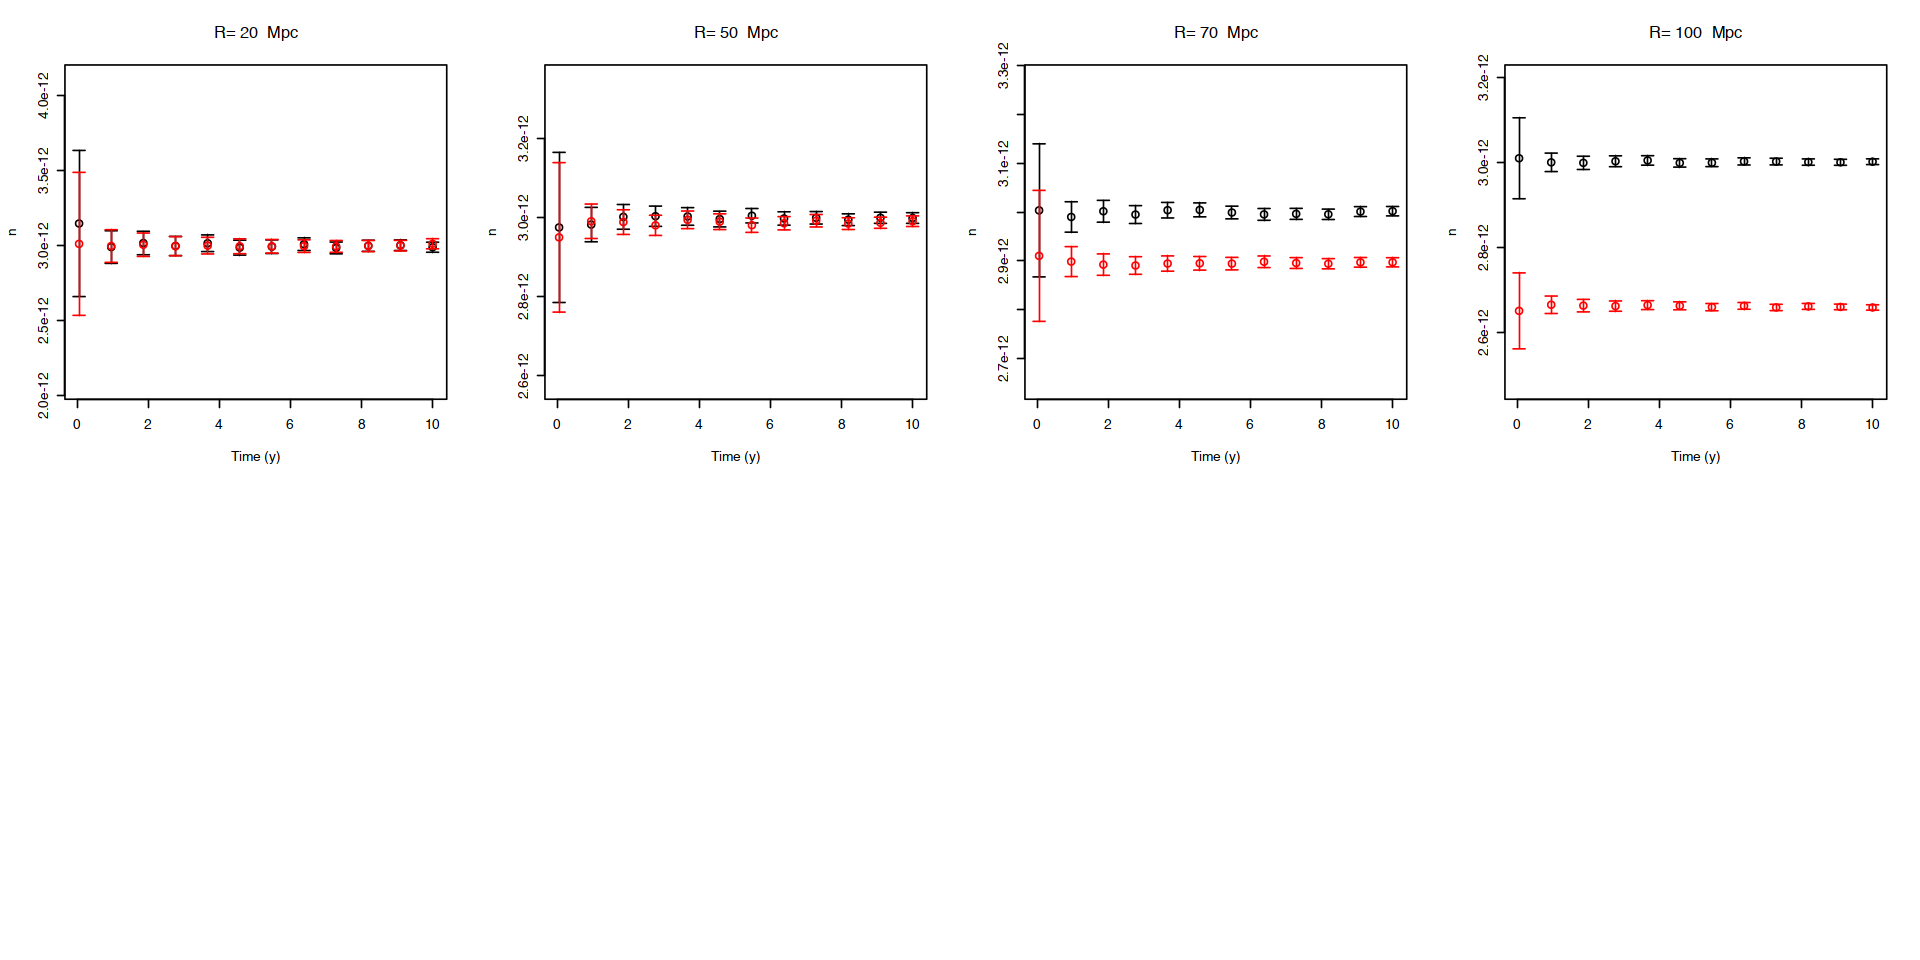

In [ ]:
par(mfrow=c(2,4))

sigma <- 5

for(i in 1:length(r_T)){
    plot(time, n_nconst[,i], xlab = "Time (y)", ylab = "n", main = paste("R=", r_T[i], " Mpc"), ylim = c(min(n_nr[,i]-10*n_err_nr[,i]), max(n_nconst[,i]+10*n_err_nconst[,i])))
    arrows(time, n_nconst[,i]-sigma*n_err_nconst[,i], time, n_nconst[,i]+sigma*n_err_nconst[,i], length = 0.05, angle = 90, code = 3 )
    points(time, n_nr[,i], col = 'red')
    arrows(time, n_nr[,i]-sigma*n_err_nr[,i], time, n_nr[,i]+sigma*n_err_nr[,i], length = 0.05, angle = 90, code = 3, col = 'red' )
}